# Transfer learning

In [29]:
%%capture
!pip install -q kaggle
!pip install torchinfo

In [3]:
%%capture
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
!rm test1.zip
!mkdir -p ./dogcat
!unzip train.zip -d ./dogcat

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./dogcat/train/dog.5499.jpg  
  inflating: ./dogcat/train/dog.55.jpg  
  inflating: ./dogcat/train/dog.550.jpg  
  inflating: ./dogcat/train/dog.5500.jpg  
  inflating: ./dogcat/train/dog.5501.jpg  
  inflating: ./dogcat/train/dog.5502.jpg  
  inflating: ./dogcat/train/dog.5503.jpg  
  inflating: ./dogcat/train/dog.5504.jpg  
  inflating: ./dogcat/train/dog.5505.jpg  
  inflating: ./dogcat/train/dog.5506.jpg  
  inflating: ./dogcat/train/dog.5507.jpg  
  inflating: ./dogcat/train/dog.5508.jpg  
  inflating: ./dogcat/train/dog.5509.jpg  
  inflating: ./dogcat/train/dog.551.jpg  
  inflating: ./dogcat/train/dog.5510.jpg  
  inflating: ./dogcat/train/dog.5511.jpg  
  inflating: ./dogcat/train/dog.5512.jpg  
  inflating: ./dogcat/train/dog.5513.jpg  
  inflating: ./dogcat/train/dog.5514.jpg  
  inflating: ./dogcat/train/dog.5515.jpg  
  inflating: ./dogcat/train/dog.5516.jpg  
  inflating: ./dogcat/train/dog.5

In [ ]:
from google.colab import files

files.upload()

In [30]:
import numpy as np
import pandas as pd
from glob import glob

import torch
from torch import nn

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import os
from tqdm import tqdm
from tempfile import TemporaryDirectory

from PIL import Image

Подготовим данные и разделим их на трейн и тест

In [5]:
images = glob("./dogcat/train/*.jpg")

In [6]:
train, test = train_test_split(images, test_size = 0.3, random_state=42)

In [7]:
class CatDogDataset(Dataset):

    def __init__(self, paths, transform = None):

        self.paths = paths
        self.transform = transform


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        label = self.paths[index].split("/")[-1].split(".")[0]

        label = 0 if label == 'cat' else 1

        image = Image.open(self.paths[index])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [8]:
# Сделаем просто ресайз и нормалайз
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
import matplotlib.pyplot as plt

def imshow(inp):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
data = {"train": train, "val" : test}
image_datasets = {x: CatDogDataset(data[x], transform=data_transform)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


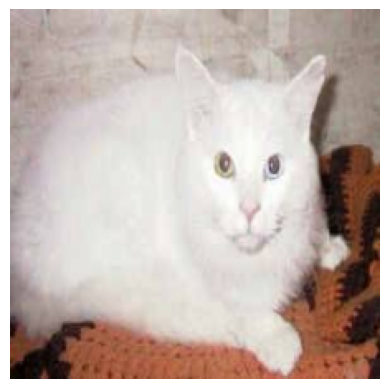

In [11]:
# Отрисуем одну картинку
imshow(image_datasets["train"].__getitem__(0)[0])

In [12]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [13]:
class_names = {0 : "cat", 1:"dog"}

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[int(preds[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Далее вам нужно взять модель ResNet 18 и дообучить её на нашем датасете. Также понадобится посчитать количество параметров модели. Вы можете использовать любой код, а можете придерживаться примера ниже.

Код очень похож на первый видеоурок темы компьютерного зрения, не стесняйтесь туда подглядывать!

Ниже нужно обозначить модель, вызвать функцию обучения, и поработать с моделью.

In [32]:
models.resnet18(weights='IMAGENET1K_V1')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


## Задание 1. Посчитайте число параметров в модели

## Задание 2. Посчитайте Params size (MB)



In [26]:
def get_params_count(model):
  return sum([p.numel() for p in model.parameters()])


print(f'Count of parameters: {get_params_count(model)}')

Count of parameters: 11177538


In [35]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## Задание 3. Обучите модель на 5 эпохах и запомните (или запишите) accuracy. Это понадобится для ответа на вопрос теста. Запомните и качество после первой эпохи.

Будьте готовы, что обучение займет минут 10 на ГПУ в коллабе. Это ещё быстро...

In [36]:
model_ft = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------


  0%|          | 0/547 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 547/547 [01:22<00:00,  6.65it/s]


train Loss: 0.1807 Acc: 0.9272


100%|██████████| 235/235 [00:30<00:00,  7.60it/s]


val Loss: 0.2090 Acc: 0.9079

Epoch 1/4
----------


100%|██████████| 547/547 [01:19<00:00,  6.84it/s]


train Loss: 0.1170 Acc: 0.9535


100%|██████████| 235/235 [00:27<00:00,  8.65it/s]


val Loss: 0.1130 Acc: 0.9560

Epoch 2/4
----------


100%|██████████| 547/547 [01:21<00:00,  6.75it/s]


train Loss: 0.0905 Acc: 0.9634


100%|██████████| 235/235 [00:30<00:00,  7.78it/s]


val Loss: 0.1050 Acc: 0.9601

Epoch 3/4
----------


100%|██████████| 547/547 [01:20<00:00,  6.81it/s]


train Loss: 0.0730 Acc: 0.9719


100%|██████████| 235/235 [00:27<00:00,  8.58it/s]


val Loss: 0.1377 Acc: 0.9467

Epoch 4/4
----------


100%|██████████| 547/547 [01:20<00:00,  6.79it/s]


train Loss: 0.0634 Acc: 0.9756


100%|██████████| 235/235 [00:29<00:00,  7.85it/s]


val Loss: 0.0883 Acc: 0.9657

Training complete in 9m 10s
Best val Acc: 0.965733


## Задание 4. Сделайте то же самое, только без предобученной архитектуры. Это задается параметром weights со значением None. Стало ли качество лучше? Запомните и его.

In [37]:
model_zero =  models.resnet18(weights=None)

model_zero.fc = nn.Linear(num_ftrs, 2)
model_zero.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_zero.parameters(), lr=0.001)

In [38]:
model_zero_ft = train_model(model_zero, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------


  0%|          | 0/547 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 547/547 [01:21<00:00,  6.72it/s]


train Loss: 0.6529 Acc: 0.6324


100%|██████████| 235/235 [00:29<00:00,  7.84it/s]


val Loss: 0.5773 Acc: 0.6940

Epoch 1/4
----------


100%|██████████| 547/547 [01:20<00:00,  6.82it/s]


train Loss: 0.5522 Acc: 0.7145


100%|██████████| 235/235 [00:29<00:00,  7.94it/s]


val Loss: 0.5672 Acc: 0.6908

Epoch 2/4
----------


100%|██████████| 547/547 [01:21<00:00,  6.69it/s]


train Loss: 0.4925 Acc: 0.7594


100%|██████████| 235/235 [00:30<00:00,  7.74it/s]


val Loss: 0.4747 Acc: 0.7709

Epoch 3/4
----------


100%|██████████| 547/547 [01:19<00:00,  6.92it/s]


train Loss: 0.4355 Acc: 0.7993


100%|██████████| 235/235 [00:29<00:00,  7.88it/s]


val Loss: 0.4272 Acc: 0.8041

Epoch 4/4
----------


100%|██████████| 547/547 [01:20<00:00,  6.77it/s]


train Loss: 0.3734 Acc: 0.8323


100%|██████████| 235/235 [00:29<00:00,  7.89it/s]

val Loss: 0.5026 Acc: 0.7741

Training complete in 9m 13s
Best val Acc: 0.804133


Посмотрим чему научилась наша модель, обученная с 0:

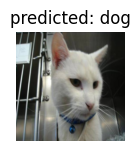

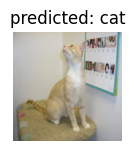

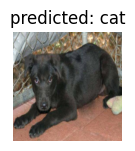

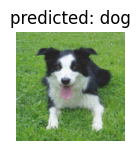

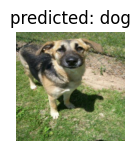

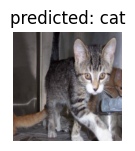

In [39]:
visualize_model(model_zero)

plt.ioff()
plt.show()

А с претрейном:

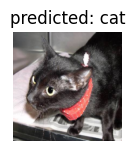

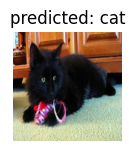

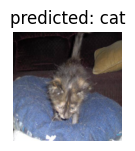

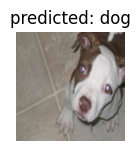

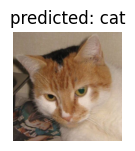

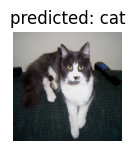

In [42]:
visualize_model(model)

plt.ioff()
plt.show()